In [ ]:
!pip install mysql-connector-python

In [ ]:
!pip install matplotlib

In [ ]:
!pip install pandas

In [2]:
from mysql.connector import connect, Error
from getpass import getpass
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
def execute_sql_script(script):
  try:
    with connect(
      host="localhost",
      user=input("Имя пользователя: "),
      password=getpass("Пароль: "),
      database="ldml",
    ) as connection:
      with connection.cursor() as cursor:
        cursor.execute(script)
        result = cursor.fetchall()
        return result
  except Error as e:
    print(e)

## Поиска журнала исследуемых документов

In [4]:
select_journals_script = """
SELECT id, title
FROM journals
ORDER BY id;
"""
select_journals_script_result = execute_sql_script(select_journals_script)

for row in select_journals_script_result:
  print(row[0], ": ", row[1])

1 :  Ученые записки Казанского университета. Серия Физико-математические науки
2 :  Известия высших учебных заведений. Математика
3 :  Исследования по подземной гидромеханике
4 :  Исследования по прикладной математике и информатике
5 :  Исследования по теории пластин и оболочек
6 :  Конструктивная теория функций и функциональный анализ
7 :  Труды геометрического семинара
8 :  Труды семинара по краевым задачам
9 :  In memoriam N. I. Lobatschevskii
10 :  Lobachevskii Journal of Mathematics
11 :  Труды математического центра имени Н. И. Лобачевского
12 :  Известия физико-математического общества 2 серия
13 :  Известия физико-математического общества 3 серия


Исследование будет проводится над документами из журнала "Труды математического центра имени Н. И. Лобачевского".

In [5]:
journal_id = 11

## Коллекция исследуемых документов

In [7]:
select_articles_count_script = f"""
SELECT COUNT(*)
FROM articles article
JOIN article_files article_file ON article_file.id = article.id
WHERE article.journal_id = {journal_id}
  AND article_file.url IS NOT NULL;
"""
select_articles_count_script_result = execute_sql_script(select_articles_count_script)

articles_count = select_articles_count_script_result[0][0]

In [8]:
print("Количество исследуемых документов: ", articles_count)

Количество исследуемых документов:  4325


## Анализ языка документов

In [9]:
lang_list = []

select_lang_script = f"""
SELECT article.lang
FROM articles article
JOIN article_files article_file ON article_file.id = article.id
WHERE article.journal_id = {journal_id}
  AND article_file.url IS NOT NULL;
"""
select_lang_script_result = execute_sql_script(select_lang_script)

for row in select_lang_script_result:
  lang_list.append(row[0])

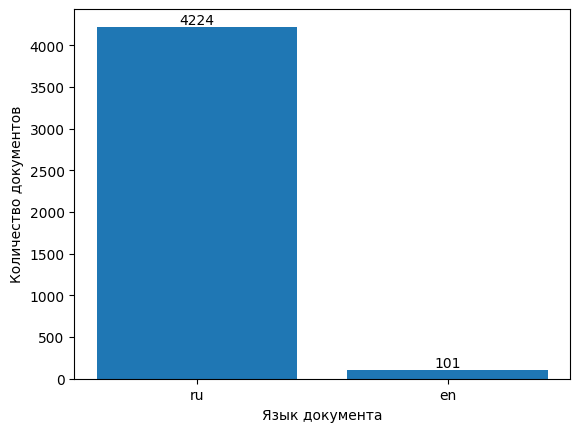

In [10]:
lang_list_counter = Counter(lang_list)
lang_keys = list(lang_list_counter.keys())
lang_values = list(lang_list_counter.values())

plt.bar(lang_keys, lang_values)
ax = plt.gca()
plt.bar_label(ax.containers[0])
plt.ylabel("Количество документов")
plt.xlabel("Язык документа")

plt.show()

## Анализ количества страниц в документах

In [11]:
pages_list = []

select_pages_script = f"""
SELECT article.pages
FROM articles article
JOIN article_files article_file ON article_file.id = article.id
WHERE article.journal_id = {journal_id}
  AND article_file.url IS NOT NULL;
"""
select_pages_script_result = execute_sql_script(select_pages_script)

for row in select_pages_script_result:
  pages_list.append(row[0])

In [12]:
print("Формат записи страниц документов в БД:", ", ".join(pages_list[:5]), "и т.д.")

Формат записи страниц документов в БД: 8-25, 26-49, 50-76, 77-77, 78-78 и т.д.


In [13]:
# Получим количество страниц для каждого документа:
pages_count_list = [abs(eval(item))+1 for item in pages_list]
pages_count_list.sort()

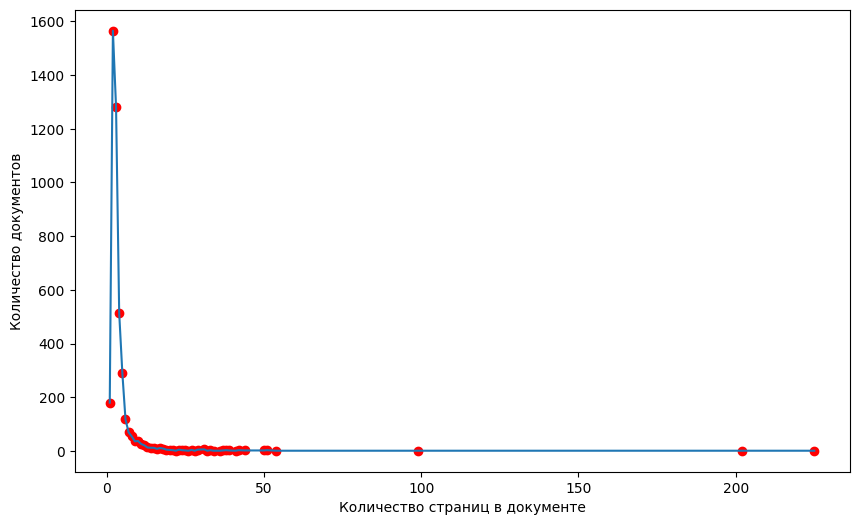

In [14]:
pages_count_list_counter = Counter(pages_count_list)
pages_count_keys = list(pages_count_list_counter.keys())
pages_count_values = list(pages_count_list_counter.values())

plt.figure(figsize=(10,6))
plt.plot(pages_count_keys, pages_count_values)
plt.scatter(pages_count_keys, pages_count_values, c="red")
plt.ylabel("Количество документов")
plt.xlabel("Количество страниц в документе")

plt.show()

In [15]:
pages_count_df = pd.DataFrame({'Количество страниц в документе': pages_count_keys, 'Количество документов': pages_count_values})
pages_count_df = pages_count_df.sort_values(by=['Количество документов', 'Количество страниц в документе'], ascending=False)
pages_count_df.reset_index(drop=True, inplace=True)

In [16]:
pages_count_df.head(10)

,Количество страниц в документе,Количество документов
0,2,1565
1,3,1281
2,4,514
3,5,291
4,1,180
5,6,118
6,7,69
7,8,54
8,10,37
9,9,36


In [29]:
pages_count_top_3_sum = sum(pages_count_df['Количество документов'].head(3))
pages_count_top_3_percent = pages_count_top_3_sum * 100 / articles_count
print(str(round(pages_count_top_3_percent, 2))+"%", "документов имеют от 2 до 4 страниц.")

77.69% документов имеют от 2 до 4 страниц.


In [17]:
pages_count_df.tail(10)

,Количество страниц в документе,Количество документов
36,202,1
37,99,1
38,54,1
39,41,1
40,36,1
41,34,1
42,32,1
43,28,1
44,26,1
45,22,1


In [18]:
pages_count_df.describe()

,Количество страниц в документе,Количество документов
count,46.000000,46.000000
mean,33.108696,94.021739
std,42.848170,301.520332
min,1.000000,1.000000
25%,12.250000,2.000000
50%,23.500000,4.000000
75%,36.750000,19.000000
max,225.000000,1565.000000
